<a href="https://colab.research.google.com/github/zinebzannouti/Web-Scraping/blob/main/1_Web_Scrapping_with_Selenium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutoriel : Extraire les articles d'une revue d'intellingence artificielle selon les catégories**

Afin de pouvoir utiliser Selenium il faut d’abord installer le Web Driver associé au navigateur que l’on souhaite utiliser. Dans mon cas, je vais utiliser le Web Driver de Chrome que vous pouvez télécharger ici.

Vous devez ensuite installer Selenium et le Web Driver dans votre environnement. Pour ce faire, on va utiliser dans notre notebook les commandes suivantes :

In [ ]:
!pip install selenium
!apt-get update 
!apt-get install chromium-browser
!apt install chromium-chromedriver
!pip install selenium-stealth

On importe les modules dont on aura besoin :

In [108]:
from selenium.webdriver.common.by import By
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium_stealth import stealth
from time import sleep
from urllib.error import HTTPError
from time import time
from selenium.common.exceptions import NoSuchElementException
import pandas as pd

Enfin, on modifie quelques options du Chrome Driver pour pouvoir l’utiliser depuis un notebook :

In [113]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)
stealth(driver,
              languages=["fr-FR", "fr"],
              vendor="Google Inc.",
              platform="Win32",
              webgl_vendor="Intel Inc.",
              renderer="Intel Iris OpenGL Engine",
              fix_hairline=True,
          )

<ipython-input-113-3a4dc5b0e958>:5: DeprecationWarning: use options instead of chrome_options
  wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
<ipython-input-113-3a4dc5b0e958>:6: DeprecationWarning: use options instead of chrome_options
  driver =webdriver.Chrome('chromedriver',chrome_options=chrome_options)


# **Web Scraping des liens des articles**
Pour pouvoir faire correctement du Web Scraping, il faut se poser deux questions :

- Comment est construit le site web ?

- Quelles données souhaite-t-on récupérer ?

Pour pouvoir avoir une idée de l’architecture du site web que l’on étudie on peut utiliser une fonctionnalité très utile disponible dans tous les navigateurs : Inspecter l’élément.

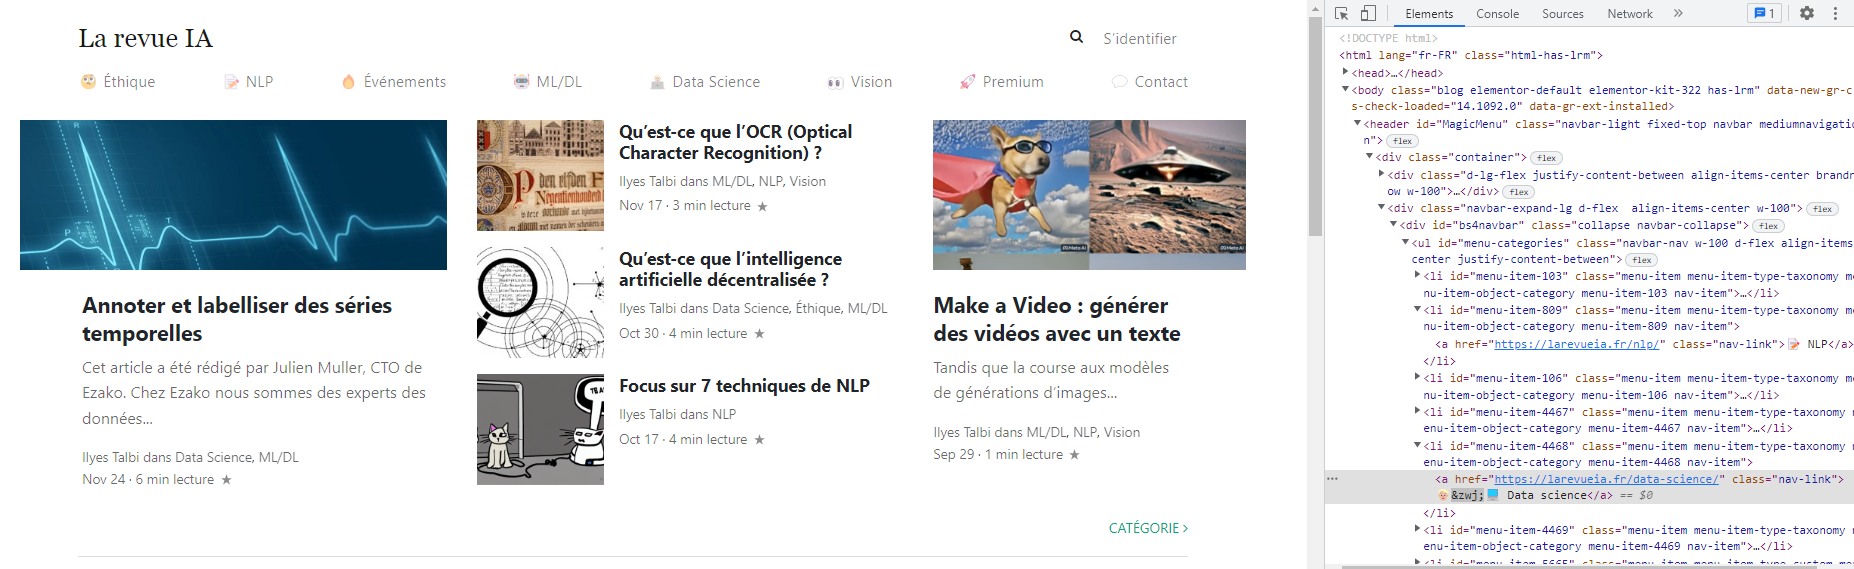

In [116]:
website="https://larevueia.fr/"

In [114]:
driver.get("https://larevueia.fr/")

Dans notre cas, on se rend vite compte que les articles sont répartis en catégories et que chaque catégorie contient plusieurs pages. On peut donc commencer par récupérer tout d’abord les liens des articles pour ensuite pouvoir récupérer les données article par article.

Pour ce faire, on va tout d’abord créer une liste contenant l’ensemble des catégories de notre site :

In [115]:
categories = ['ethique', 'nlp', 'evenements', 'ml-dl', 'data-science', 'vision']

On peut donc facilement explorer le site en parcourant les liens des pages des différentes catégories :

In [118]:
articles_links = []
for category in categories:
  category_link = website + category
  driver.get(category_link)
  href_links = driver.find_elements(By.XPATH,'//h2/a[@href]')
  for href_link in href_links:
    articles_links.append([href_link.get_attribute('href'), category])

Pour expliquer plus précisément ce que fait le code ci-dessus, on peut dire que l’on parcourt tout d’abord la liste des catégories, pour chaque catégorie on crée une variable, qui contient son URL. Puis on ouvre la page avec la fonction get() de notre driver.

On utilise ensuite la fonction find_elements_by_xpath() pour rechercher les liens href se trouvant à l’intérieur de balise h2 (ceci découle directement de notre analyse du site avec la fonctionnalité Inspecter l’élément de notre navigateur, vous pouvez copier le xpath directement sur le navigateur).

Finalement, on ne récupère que le lien de l’article avec la fonction get_attribute(), et on ajoute donc à notre liste le lien de l’article ainsi que la catégorie à laquelle il correspond (ce qui peut être utile plus tard pour faire du NLP avec un modèle de classification par exemple).

On pourrait aller plus loin et rajouter une deuxième boucle pour incrémenter à chaque fois le nombre de pages afin de parcourir tous les articles de chaque catégorie, et pas seulement ceux présents sur la première page.

# **Web Scraping du contenu des articles avec Selenium**
Une fois l’ensemble des liens d’articles récupérés, la prochaine étape est d’analyser le contenu de la page pour chaque article. Encore une fois, on utilise la fonctionnalité Inspecter l’élément, afin d’identifier la structure de la page et de retrouver les éléments à scraper.

On se rend vite compte que dans notre cas le contenu de l’article est stocké dans une classe nommée article-post. On va donc récupérer le contenu texte de cette classe et tout stocker dans un data frame avec Pandas :

In [119]:
df_articles = pd.DataFrame()
for article_link in articles_links:
  driver.get(article_link[0])
  content_scrap = driver.find_elements(By.CLASS_NAME,'article-post')
  if (len(content_scrap) != 0):
    content = content_scrap[0].text
  article = {'category' : article_link[1], 'content' : content}
  df_article = pd.DataFrame(article, index = [0])
  df_articles = df_articles.append(df_article, ignore_index=True)

On se retrouve donc avec un data frame contenant nos articles, avec à chaque fois la catégorie à laquelle il correspond. On peut finalement transformer ce data frame en fichier csv, afin de stocker les données :

In [120]:
df_articles.to_csv('la_revue_ia_articles.csv')

In [121]:
df_articles

,category,content
0,ethique,"Le web2 est cassé. Et comme lui, l’IA est cass..."
1,ethique,Un des avantages des réseaux de neurones résid...
2,ethique,Depuis qu’Alan Turing a introduit la question ...
3,ethique,"Dans cet article, on vous explique comment uti..."
4,ethique,"Il y a 3 ans, après la tech expo de San Franci..."
5,ethique,Si vous vous intéressez aux modèles de traitem...
6,ethique,Ces derniers temps je me suis mis à scaner tou...
7,ethique,Les applications de l’intelligence artificiell...
8,ethique,On met souvent en avant les prouesses des syst...
9,ethique,Les éditions Eyrolles m’ont gentiment envoyés ...
